#I. Data Loading

In [191]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
df = pd.read_csv('/content/drive/MyDrive/Bitcoin_2010toPresent.csv', delimiter= ';')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [192]:
bitcoin = df[['timeClose','close']]
bitcoin['timeClose']= pd.to_datetime(bitcoin['timeClose']).dt.strftime('%Y-%m-%d')
bitcoin = bitcoin.sort_values(by = 'timeClose').reset_index(drop = True)
bitcoin

,timeClose,close
0,2010-07-14,0.056402
1,2010-07-15,0.057568
2,2010-07-16,0.066492
3,2010-07-17,0.065993
4,2010-07-18,0.078814
...,...,...
5445,2025-06-10,110257.237712
5446,2025-06-11,108686.627682
5447,2025-06-12,105929.051263
5448,2025-06-13,106090.966395


Text(0, 0.5, 'Close Price')

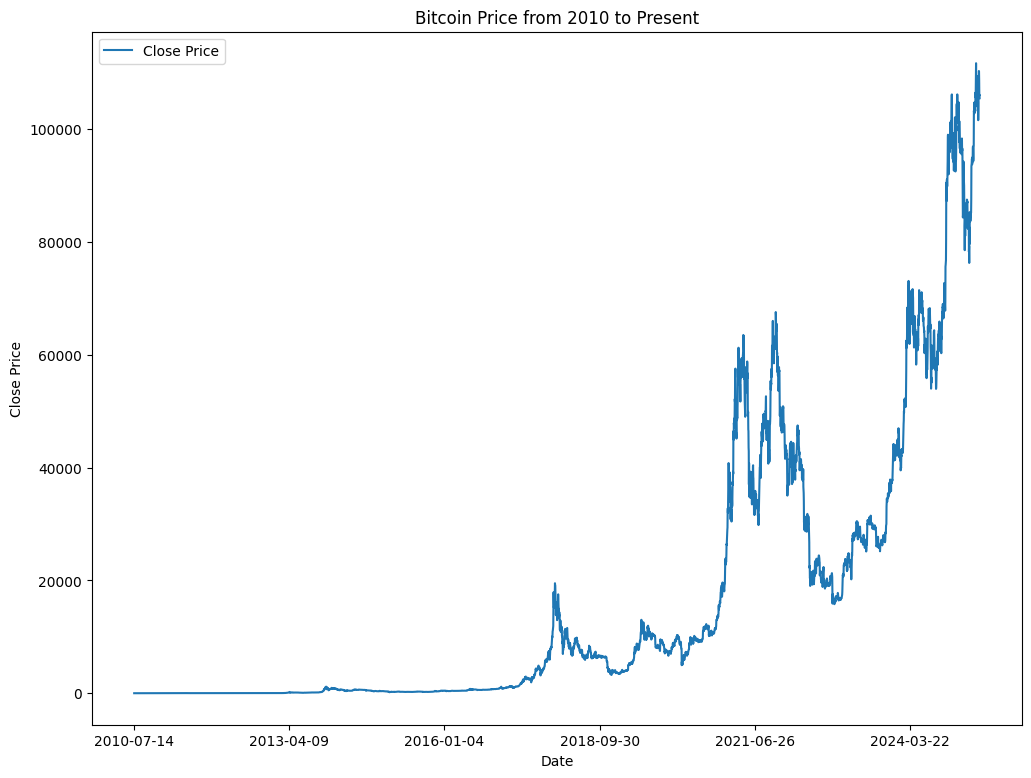

In [193]:
lineplot = bitcoin.plot(x = 'timeClose', y ='close', label = 'Close Price', figsize = (12,9))
lineplot.set_title('Bitcoin Price from 2010 to Present')
lineplot.set_xlabel('Date')
lineplot.set_ylabel('Close Price')

Although overall there is an increasing trend in Bitcoin price, it has been highly volatile over time, with repeated sharp plunges followed by strong recoveries and surges. From external sources, I have identified some notable booms and crashes:
1. June 2011: from 32 USD, the price plummeted to 0.01 USD due to a security breach on Mt.Gox's platform, a Japanese cryptocurrency exchange.
2. Late 2013 to 2015: started to witness a decrease trend because the Chinese central bank prohibited local financial institutions from conducting Bitcoin transactions
3. January 2018: plummeted from around 20,000 USD to 3200 USD as a consequence of security issues associated with Coincheck, a Japanese cryptocurrency exchange.
4. June 2021: price crash due to raising environmental concerns regarding Bitcoin mining.
5. May 2022: negative domino effect caused by the collapse of Terra, a crypto lender.
Also, I noticed that there have been certain periodic surges, which are likely to coincide with Bitcoin's 4-year halving events in 2012, 2016, 2020, and 2024 respectively.

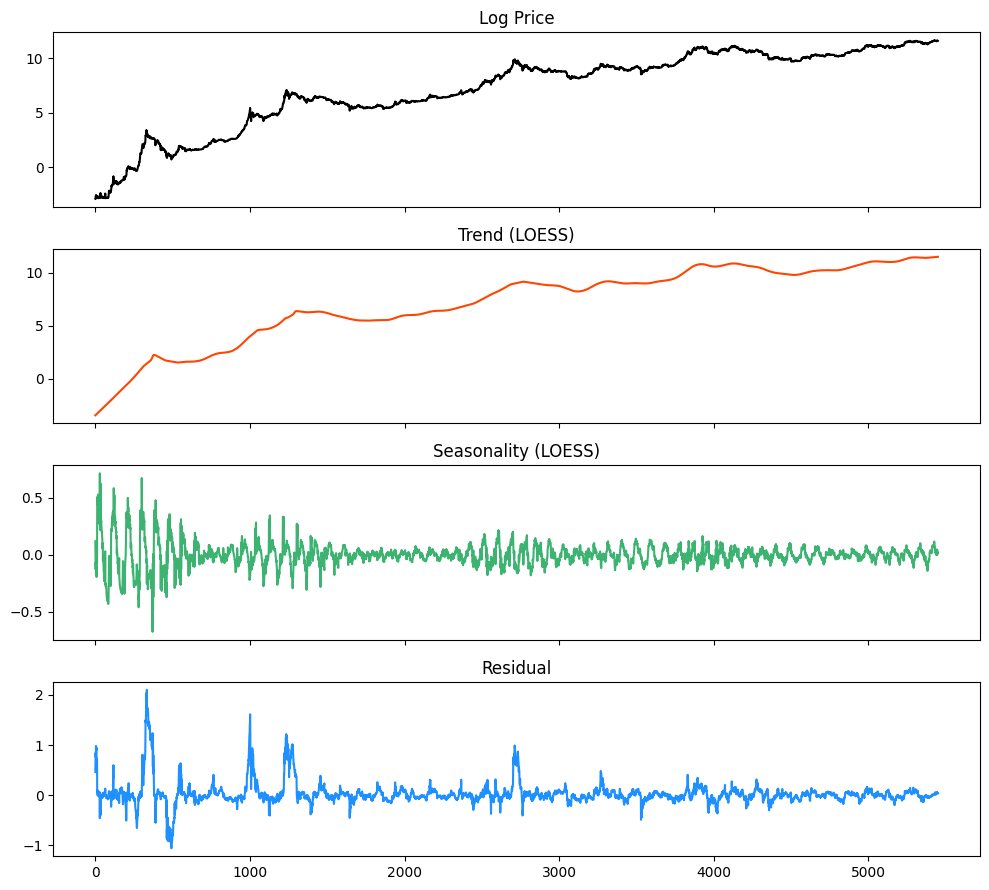

In [194]:
from statsmodels.tsa.seasonal import STL
log_price = np.log(bitcoin['close'])
stl = STL(log_price, period=90, robust=True)
result = stl.fit()
fig, axs = plt.subplots(4, 1, figsize=(10, 9), sharex=True)
axs[0].plot( log_price, label='Log Price', color='black')
axs[0].set_title("Log Price")
axs[1].plot( result.trend, label='Trend', color='orangered')
axs[1].set_title("Trend (LOESS)")
axs[2].plot(result.seasonal, label='Seasonal', color='mediumseagreen')
axs[2].set_title("Seasonality (LOESS)")
axs[3].plot( result.resid, label='Residuals', color='dodgerblue')
axs[3].set_title("Residual")
plt.tight_layout()
plt.show()

I could not identity any clear seasonality in Bitcoin's price, therefore I won't proceed with SARIMA in this assignment.

#II. Stationary Test

In general, there is an upward trend in Bitcoin's price, so I suspect that this time-series is non-stationary. We will validate it further by using ACF and DACF Plot.


##1. ACF Plot

Text(0.5, 1.0, 'Autocorrelation Function (ACF)')

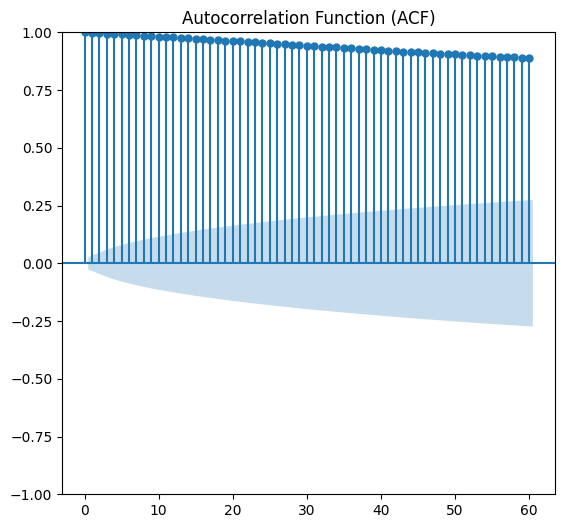

In [195]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plot_acf(bitcoin['close'], ax=plt.gca(), lags=60)
plt.title('Autocorrelation Function (ACF)')


As shown on the plot, the ACF decays slowly => the time-series is non-stationary.

Text(0.5, 1.0, 'ACF after Differencing')

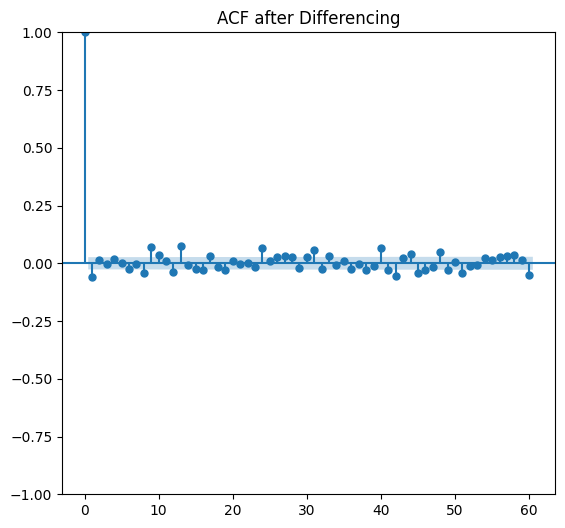

In [196]:
bitcoin_diff = bitcoin['close'].diff().dropna()
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plot_acf(bitcoin_diff, ax=plt.gca(), lags = 60)
plt.title('ACF after Differencing')

At first glance, our ACF seemingly has no spike beyond lag 1 => we choose d=1 and q = 0 for the ARIMA Model. However, when analyzing each lag more cautiously, there are a lot of lags that has correlation outside the confidence interval. Therefore, I will further use ADF Test to double check stationary.

In [197]:
#ADF Test
from statsmodels.tsa.stattools import adfuller
result_adf = adfuller(bitcoin_diff)
print('ADF Statistic:', result_adf[0])
print('p-value:', result_adf[1])
for key, value in result_adf[4].items():
    print(f'Critical Value ({key}): {value}')

ADF Statistic: -10.727837343275466
p-value: 3.0331387849739053e-19
Critical Value (1%): -3.431557530619635
Critical Value (5%): -2.862073607019783
Critical Value (10%): -2.567054038105758


p-value = 3.03e-19, an extremely small number => we can reject the null hypothesis of a unit root, indicating that the differenced series is stationary. However, since a lot of lags (small spikes) are outside the confidence interval, I will use other methods to find the optimal q.

##PACF Plot

<Figure size 1400x600 with 0 Axes>

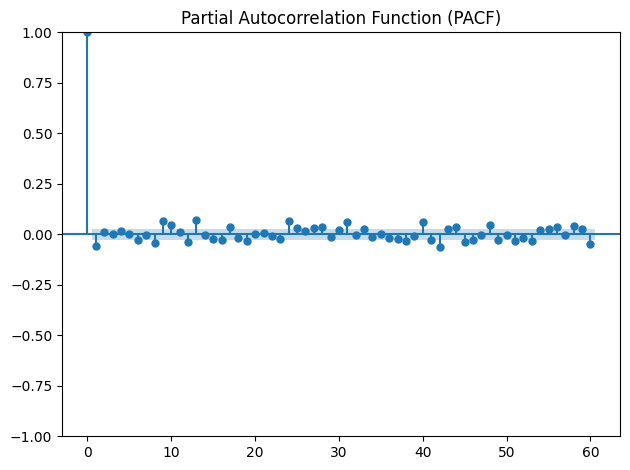

In [198]:
plt.figure(figsize=(14, 6))
plot_pacf(bitcoin_diff, lags=60, method='ywm')
plt.title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

The same issue with my ADF plot was witnessed: although there is no significant spike after lag 0, there are a lot of small spikes. Therefore, I will determine the optimal p and q by minimizing AIC.

#III. ARIMA Model

In [199]:
train_size = int(len(bitcoin) * 0.8)
train_set = bitcoin['close'][:train_size]
test_set = bitcoin['close'][train_size:]

In [200]:
import warnings
import itertools
p = range(0, 5)
q = range(0, 5)
d = 1
warnings.filterwarnings("ignore")
best_aic = float("inf")
best_order = None
for param in itertools.product(p, q):
    try:
        model = sm.tsa.ARIMA(train_set, order=(param[0], d, param[1])).fit()
        if model.aic < best_aic:
            best_aic = model.aic
            best_order = param
    except:
        continue
print("Best ARIMA order:", best_order, "with AIC:", best_aic)

Best ARIMA order: (4, 4) with AIC: 68798.13344226917


In [201]:
model_arima = ARIMA(train_set, order=(4,1,4))
result_arima = model_arima.fit()
print(result_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 4360
Model:                 ARIMA(4, 1, 4)   Log Likelihood              -34390.067
Date:                Mon, 16 Jun 2025   AIC                          68798.133
Time:                        00:28:50   BIC                          68855.553
Sample:                             0   HQIC                         68818.399
                               - 4360                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4817      0.007    -67.594      0.000      -0.496      -0.468
ar.L2          0.7106      0.005    151.170      0.000       0.701       0.720
ar.L3         -0.5282      0.004   -119.153      0.0


Mean Squared Error: 1648893016.842583
Mean Absolute Error: 29673.295999320293
MAPE: 45.30677247033908 %


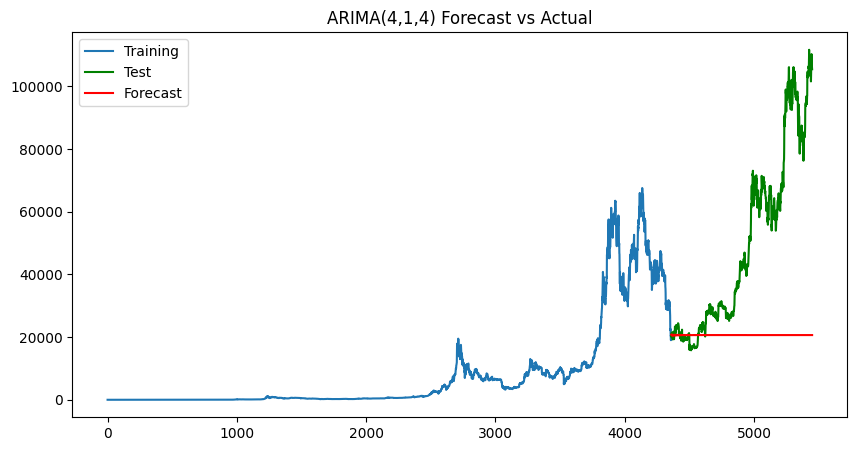

In [202]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
forecast_arima = result_arima.forecast(steps=len(test_set))
mse_arima = mean_squared_error(test_set, forecast_arima)
mae_arima = mean_absolute_error(test_set, forecast_arima)
mape_arima = (abs(test_set - forecast_arima) / abs(test_set)).mean() * 100
print("\nMean Squared Error:", mse_arima)
print("Mean Absolute Error:", mae_arima)
print("MAPE:", mape_arima, "%")
plt.figure(figsize=(10,5))
plt.plot(train_set.index, train_set, label='Training')
plt.plot(test_set.index, test_set, label='Test', color='green')
plt.plot(test_set.index, forecast_arima, label='Forecast', color='red')
plt.legend()
plt.title('ARIMA(4,1,4) Forecast vs Actual')
plt.show()

Overall, my ARIMA Model performed quite bad in predicting the test set. In general, my ARIMA only returned "a straight line". Before pointing out several drawbacks of this method, I will try some alternative models first.


#IV. Holt's Linear

Because the time-series demonstrated a trend overtime but no clear seasonal pattern, I will try to compare ARIMA with Holt's Linear.

In [203]:
from statsmodels.tsa.holtwinters import Holt
best_score_holt = float('inf')
best_params_holt = (None, None)
for alpha in np.arange(0.1, 1.0, 0.1):
    for beta in np.arange(0.1, 1.0, 0.1):
        model_holt = Holt(train_set).fit(
            smoothing_level=alpha,
            smoothing_slope=beta,
            optimized=False
        )
        forecast_holt = model_holt.forecast(len(test_set))
        mape_holt = mean_absolute_percentage_error(test_set, forecast_holt) * 100
        if mape_holt < best_score_holt:
            best_score_holt = mape_holt
            best_params_holt = (alpha, beta)
print("Best alpha, beta:", best_params_holt)
print("Best MAPE:", best_score_holt)


Best alpha, beta: (np.float64(0.8), np.float64(0.4))
Best MAPE: 26.425711364664124


The optimal alpha and beta quite align with the characteristics of Bitcoin. First, a high alpha of 0.8 indicates the high importance of recent data on predicting future price, compared to historical data. Additionally, a moderate beta is able to track the price trend with caution.

MSE: 347906200.10
MAE: 13761.59
MAPE: 26.43%


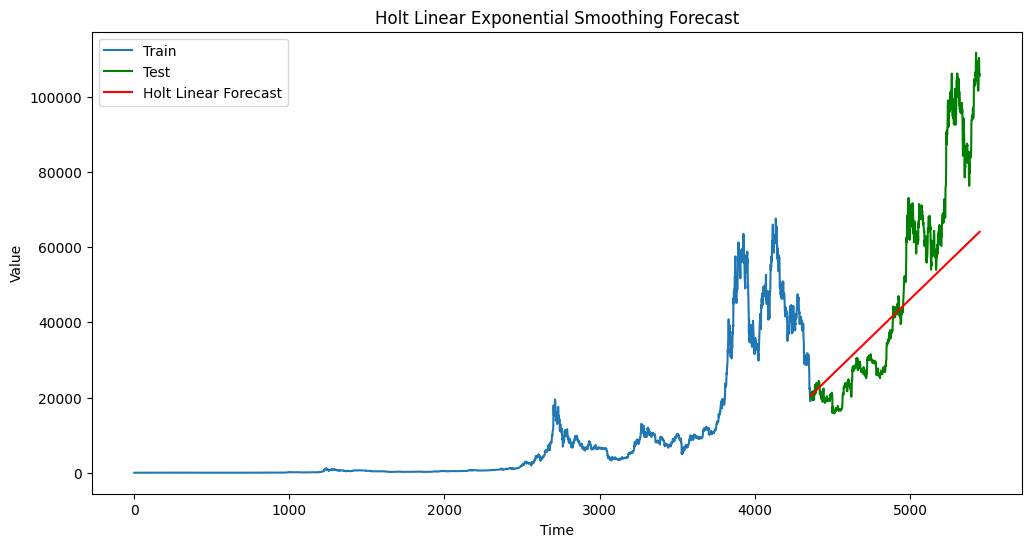

In [204]:
model_h1 = Holt(train_set).fit(smoothing_level=0.8, smoothing_slope=0.4, optimized=False)
forecast_h1 = model_h1.forecast(len(test_set))
mse_holt = mean_squared_error(test_set, forecast_h1)
mae_holt = mean_absolute_error(test_set, forecast_h1)
mape_h1 = mean_absolute_percentage_error(test_set, forecast_h1) * 100
print(f'MSE: {mse_holt:.2f}')
print(f'MAE: {mae_holt:.2f}')
print(f'MAPE: {mape_h1:.2f}%')
plt.figure(figsize=(12,6))
plt.plot(train_set.index, train_set, label='Train')
plt.plot(test_set.index, test_set, label='Test', color='green')
plt.plot(test_set.index, forecast_h1, label='Holt Linear Forecast', color='red')
plt.title('Holt Linear Exponential Smoothing Forecast')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

At least, my Holt's Linear Model performed better in terms of predicting the overall upward trend.

#V. Regime-Switching

I found the 4-year halving event quite crucial in shaping Bitcoin's price, so I wanna inspect whether regime switches align with, at least, 2 halving events (and other market shocks as well).
Initially, I wanted to run the model from 2010 to present, but no matter what I tried, the output kept returning the "SVD did not coverge" error. Therefore, I shifted my goal to the previous 10 years only. My hypothesis is that there would be 3 regimes in total:
- One with high positive return, high volatility (Bull)
- One with high negative return, high volatility (Bear)
- One with low volatility

In [205]:
bitcoin_10years = bitcoin.loc['2016-01-01':].copy().reset_index(drop =True)
bitcoin_10years['log_return'] = np.log(bitcoin_10years['close']) - np.log(bitcoin_10years['close'].shift(1))
bitcoin_10years.dropna(inplace=True)
bitcoin_10years

,timeClose,close,log_return
1,2016-01-22,382.492004,-0.070088
2,2016-01-23,387.490997,0.012985
3,2016-01-24,402.971008,0.039172
4,2016-01-25,391.726013,-0.028302
5,2016-01-26,392.153015,0.001089
...,...,...,...
3428,2025-06-10,110257.237712,-0.000334
3429,2025-06-11,108686.627682,-0.014347
3430,2025-06-12,105929.051263,-0.025699
3431,2025-06-13,106090.966395,0.001527


In [206]:
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
model_regime = MarkovRegression(bitcoin_10years['log_return'], k_regimes=3, trend='c', switching_variance=True)
result_regime = model_regime.fit(disp = False)
print(result_regime.summary())

                        Markov Switching Model Results                        
Dep. Variable:             log_return   No. Observations:                 3432
Model:               MarkovRegression   Log Likelihood                7212.021
Date:                Mon, 16 Jun 2025   AIC                         -14400.042
Time:                        00:29:02   BIC                         -14326.351
Sample:                             0   HQIC                        -14373.716
                               - 3432                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.000      1.782      0.075   -7.21e-05       0.002
sigma2      7.472e-05   1.18e-05      6.345      0.0

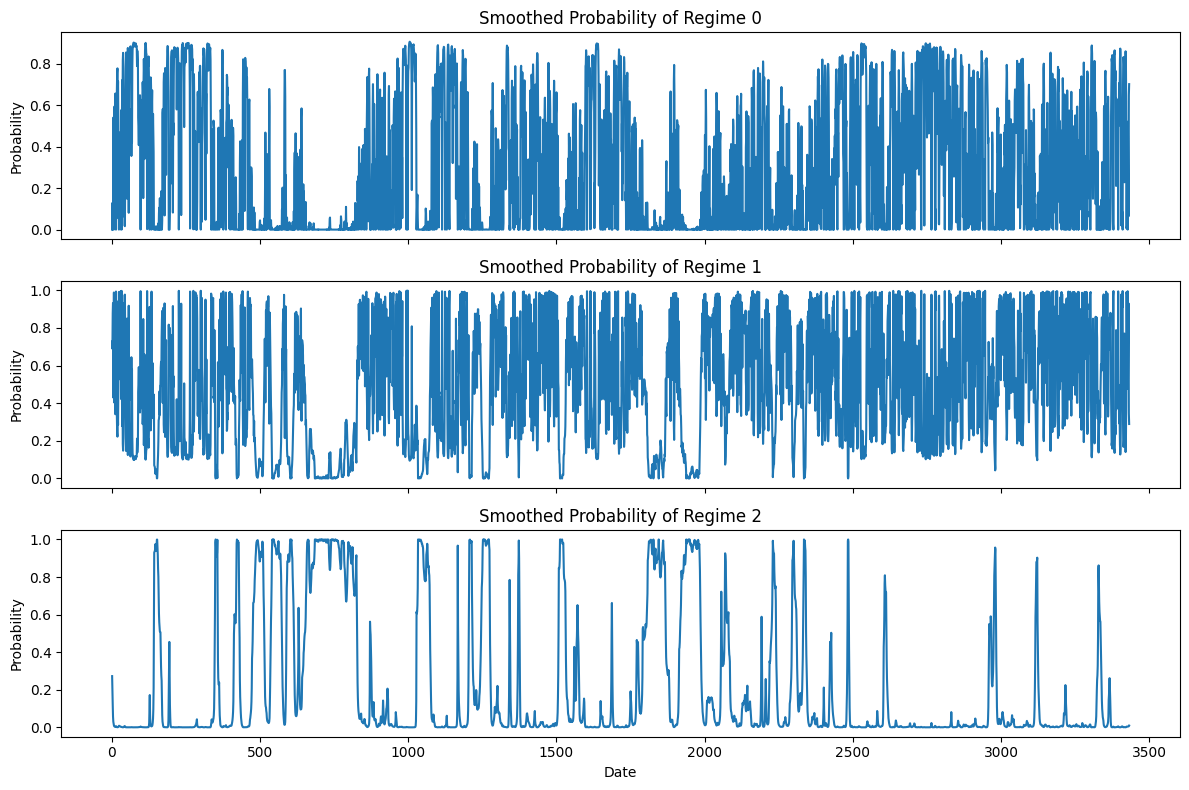

In [207]:
smoothed_probs = result_regime.smoothed_marginal_probabilities
smoothed_probs.index = bitcoin_10years.index
fig, axes = plt.subplots(3, figsize=(12, 8), sharex=True)
for i in range(3):
    axes[i].plot(smoothed_probs.index, smoothed_probs[i])
    axes[i].set_title(f"Smoothed Probability of Regime {i}")
    axes[i].set_ylabel('Probability')
axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()

In [208]:
bitcoin_10years['regime'] = result_regime.smoothed_marginal_probabilities.idxmax(axis=1)
regime_stats = bitcoin_10years.groupby('regime')['log_return'].agg(['mean', 'std'])
print(regime_stats)

            mean       std
regime                    
0       0.000548  0.006712
1       0.003302  0.032131
2      -0.000302  0.062040


According to the descriptive statistics, we can classify and label each regime as:
- Regime 0: stable, low volatility
- Regime 1: Bull Market
- Regime 2: Bear Market

Let's test these findings with some real market shocks.

In [209]:
halving_dates = ['2016-07-09', '2020-05-11', '2024-04-20']
halving_dates = pd.to_datetime(halving_dates)
bitcoin_10years.index = pd.to_datetime(bitcoin_10years['timeClose'])
for date in halving_dates:
    closest_pos = bitcoin_10years.index.get_indexer([date], method='nearest')[0]
    closest_date = bitcoin_10years.index[closest_pos]
    regime_on_date = bitcoin_10years['regime'].iloc[closest_pos]
    print(f"Halving around {date.date()} (closest trading day {closest_date.date()}): Regime {regime_on_date}")

Halving around 2016-07-09 (closest trading day 2016-07-09): Regime 1
Halving around 2020-05-11 (closest trading day 2020-05-11): Regime 2
Halving around 2024-04-20 (closest trading day 2024-04-20): Regime 1


The outcomes were quite desirable, with 2 halving dates were classified as regime 1(bull market). Intuitively, I would also expect a surge in Bitcoin price after an halving event. Instead of predicting the exact price (which is quite impossible in my opinion), I will predict the probability of each regime for the next 30 days.

In [210]:
params = result_regime.params
k_regimes = 3
n_trans_params = (k_regimes - 1) * k_regimes
trans_params = params[-n_trans_params:]
transition_matrix = np.zeros((k_regimes, k_regimes))
index = 0
for i in range(k_regimes):
    if i < k_regimes - 1:
        logits = trans_params[index:index + k_regimes]
        index += k_regimes
        exp_logits = np.exp(logits)
        transition_matrix[i, :] = exp_logits / exp_logits.sum()
    else:
        transition_matrix[i, :] = 1.0 / k_regimes

In [218]:
last_probs = result_regime.smoothed_marginal_probabilities.iloc[-1].values
future_probs = []
current_probs = last_probs
for day in range(30):
    next_probs = np.dot(current_probs, transition_matrix)
    future_probs.append(next_probs)
    current_probs = next_probs
future_probs_df = pd.DataFrame(future_probs, columns=[f'Regime_{i}' for i in range(transition_matrix.shape[0])])
future_probs_df.index = pd.date_range(start=bitcoin_10years.index[-1] + pd.Timedelta(days=1), periods=30)
print(future_probs_df.head(10))

            Regime_0  Regime_1  Regime_2
2025-06-15  0.333073  0.333683  0.333243
2025-06-16  0.333111  0.333459  0.333430
2025-06-17  0.333111  0.333459  0.333430
2025-06-18  0.333111  0.333459  0.333430
2025-06-19  0.333111  0.333459  0.333430
2025-06-20  0.333111  0.333459  0.333430
2025-06-21  0.333111  0.333459  0.333430
2025-06-22  0.333111  0.333459  0.333430
2025-06-23  0.333111  0.333459  0.333430
2025-06-24  0.333111  0.333459  0.333430


However, I encountered a problem here. Because I used the probability of the most recent date as the transition matrix, as a nature of the Markov Chain, in long-run, the probability will converge to the stationary distribution of the chain. Therefore, I think this approach might be suitable for short-term prediction such as 3 days ahead. ChatGPT suggested me a simulated approach, but to be honest I have no faith in its accuracy. I will put it here only to better understand and visualize the stochastic process of the cryptocurrency market.

In [224]:
def simulate_regime_path(transition_matrix, start_regime, steps=30, seed=42):
    np.random.seed(seed)
    regimes = [start_regime]
    current = start_regime
    for _ in range(steps - 1):
        current = np.random.choice(transition_matrix.shape[1], p=transition_matrix[current])
        regimes.append(current)
    return regimes
start_regime = np.argmax(result_regime.smoothed_marginal_probabilities.iloc[-1].values)
sim_path = simulate_regime_path(transition_matrix, start_regime, steps=30)

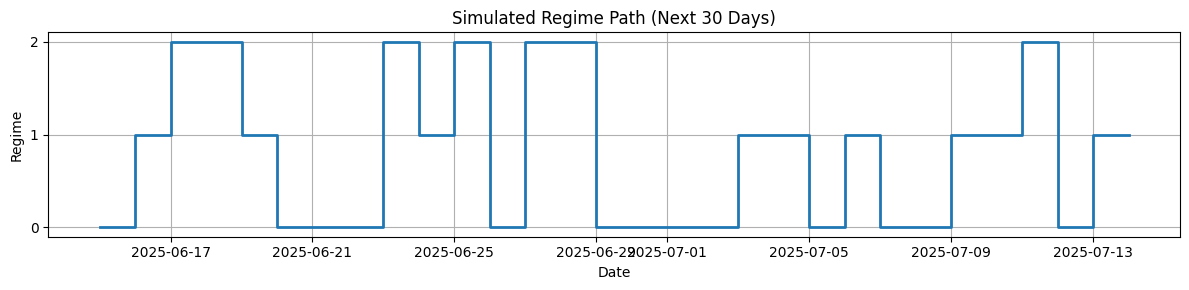

In [225]:
future_dates = pd.date_range(start=bitcoin_10years.index[-1] + pd.Timedelta(days=1), periods=30)
simulated_regimes_df = pd.DataFrame({'Date': future_dates, 'Simulated_Regime': sim_path})
plt.figure(figsize=(12, 3))
plt.plot(simulated_regimes_df['Date'], simulated_regimes_df['Simulated_Regime'], drawstyle='steps-post', lw=2)
plt.title("Simulated Regime Path (Next 30 Days)")
plt.xlabel("Date")
plt.ylabel("Regime")
plt.yticks(range(transition_matrix.shape[0]))
plt.grid(True)
plt.tight_layout()
plt.show()

#VI. OVERALL REFLECTION:
In forecasting Bitcoin prices, ARIMA demonstrates clear limitations in capturing the dynamic nature of cryptocurrency markets. In practice, ARIMA tends to produce a flat or overly smoothed forecast, especially when applied to highly volatile and non-stationary assets like Bitcoin. This is largely due to its reliance on historical linear patterns and its assumption of a stationary time series after differencing. As a result, ARIMA fails to account for structural changes, trends, or volatility clustering that are typical in financial time series.
In contrast, Holt’s linear model better captures Bitcoin’s upward momentum by incorporating a trend component explicitly. Meanwhile, regime-switching models offer a more adaptive approach, estimating the probability of the market shifting between bull, bear, and stable regimes—something ARIMA is structurally unequipped to handle. These observations underscore ARIMA’s core weakness: its inability to model non-linearities and abrupt changes in market behavior, which are crucial for effective cryptocurrency forecasting.

In this assignment, I just want to focus on ARIMA and other econometrics tools. I am curious about the effectiveness of LSTM in solving this task, so I intend to continue with it soon. For a highly volatile asset like Bitcoin, I wonder which models can be served as the ideal tool, maybe a hybrid approach between GARCH and LSTM :<?